# k-Nearest Neighbors Regression to predict house prices

In [1]:
import numpy as np
import pandas as pd

In [6]:
#loading the different sets of data training, test and validation sets
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv("kc_house_data_small.csv", dtype=dtype_dict)
train = pd.read_csv("kc_house_data_small_train.csv", dtype=dtype_dict)
test = pd.read_csv("kc_house_data_small_test.csv", dtype=dtype_dict)
valid = pd.read_csv("kc_house_data_validation.csv", dtype=dtype_dict)

In [10]:
#function to convert into numpy array

def convert_into_numpy_matrix(data_frame, features, output):
    data_frame['constant'] = 1
    features = ['constant']+features
    features_matrix = data_frame[features].as_matrix()
    output_df = data_frame[output]
    return (features_matrix, output_df)

#function to normalize fetaures

def normalize_fetaures(features_matrix):
    norms = np.linalg.norm(features_matrix, axis=0)
    normalized_features = features_matrix/norms
    return(normalized_features, norms)

In [42]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']

#converting data into numpy matrices
train_matrix, train_output = convert_into_numpy_matrix(train, feature_list, 'price')
test_matrix, test_output = convert_into_numpy_matrix(test, feature_list, 'price')
valid_matrix, valid_output = convert_into_numpy_matrix(valid, feature_list, 'price')

#normalizing data
normalized_train_matrix, norms = normalize_fetaures(train_matrix)
normalized_test_matrix = test_matrix/norms
normalized_valid_matrix = valid_matrix/norms

In [113]:
#calculating the simple euclidean distance
print round(np.sqrt(sum((normalized_test_matrix[0] - normalized_train_matrix[9])**2)),3), "\n"

for i in range(10):
    euclidean_dist = np.sqrt(sum((normalized_test_matrix[0] - normalized_train_matrix[i])**2))
    print i, " : ", euclidean_dist

0.06 

0  :  0.060274709163
1  :  0.0854688114764
2  :  0.0614994643528
3  :  0.0534027397929
4  :  0.0584448406017
5  :  0.0598792150981
6  :  0.0546314049678
7  :  0.0554310832361
8  :  0.0523836278402
9  :  0.059723593714


### vector operations instead of loops

In [25]:
#vectorization test

# verify that vectorization works
results = normalized_train_matrix[0:3] - normalized_test_matrix[0]
print results[0] - (normalized_train_matrix[0]-normalized_test_matrix[0])
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print results[1] - (normalized_train_matrix[1]-normalized_test_matrix[0])
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print results[2] - (normalized_train_matrix[2]-normalized_test_matrix[0])
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [119]:
#testing purposes
query_house = normalized_test_matrix[0]
diff = normalized_train_matrix - query_house
print diff[-1].sum()
print sum(diff[15]**2) == np.sum(diff**2, axis=1)[15]

distance = np.sqrt(np.sum(diff**2, axis=1))
print distance[100]

-0.0934339987465
True
0.0237082324167


## 1-nearest neighbor

In [69]:
#function to compute distances from a query house to all training houses

def compute_distance(features_matrix, query_vector):
    difference = features_matrix - query_vector
    euclidean_distance = np.sqrt(np.sum(difference**2, axis=1))
    return euclidean_distance

all_distances = compute_distance(normalized_train_matrix, normalized_test_matrix[2])

print np.where(all_distances == all_distances.min())[0]

print train['price'][382]
print test['price'][2]

[382]
249000.0
438000.0


## k-nearest neighbor

In [73]:
#k-nearest neighbors regression

def k_nearest_neighb(k, features_matrix, query_vector):
    distances = compute_distance(features_matrix, query_vector)
    sorted_indices = np.argsort(distances, kind='quicksort')
    return sorted_indices[0:k]

nearest_4_indices = k_nearest_neighb(4, normalized_train_matrix, normalized_test_matrix[2])
print nearest_4_indices

for i in nearest_4_indices:
    print train['price'][i]

[ 382 1149 4087 3142]
249000.0
477000.0
499950.0
430000.0


## simple averaging method for prediction in k nearest neighbor

In [82]:
#simple averaging method for prediction of houses
def predict_output_of_query(k, features_train, output_train, query_vector):
    k_nearest_indices = k_nearest_neighb(k, features_train, query_vector)
    k_nearest_avg_price = np.mean(output_train[k_nearest_indices])
    return k_nearest_avg_price

predict_output_of_query(4, normalized_train_matrix, train['price'], normalized_test_matrix[2])

413987.5

In [103]:
#predicting for multiple inputs at once
def predict_multiple_queries(k, features_train, output_train, query_vector):
    predictions = list()
    for i in range(0, query_vector.shape[0]):
        pred = predict_output_of_query(k, features_train, output_train, query_vector[i])
        predictions.append(pred)
    return predictions

predict_multiple_queries(10,normalized_train_matrix, train['price'],normalized_test_matrix[0:10])

[881300.0,
 431860.0,
 460595.0,
 430200.0,
 766750.0,
 667420.0,
 350032.0,
 512800.70000000001,
 484000.0,
 457235.0]

## choosing the best k to use in knn

In [122]:
#function to calculate rss
def calculate_rss(predictions, true_outputs):
    residuals = predictions - true_outputs
    rss = np.sum(residuals**2)
    return rss

#function to give a dictionary of k and corresponding rss values
def choose_k_for_knn(k_set, features_train, output_train, query_vector, actual_output):
    rss_dict = {}
    for i in k_set:
        my_predictions = predict_multiple_queries(i, features_train, output_train, query_vector)
        my_rss = calculate_rss(my_predictions,actual_output)
        rss_dict[i] = my_rss        
    return rss_dict

my_ks = [i for i in range(1,16)]
my_rss_dict = choose_k_for_knn(my_ks,normalized_train_matrix,train['price'],normalized_valid_matrix, valid['price'])

## plotting k vs corresponding rss values

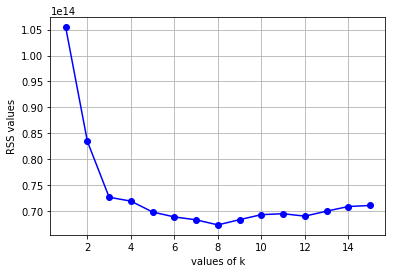

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(my_ks, list(my_rss_dict.values()), 'bo-')
plt.xlabel("values of k")
plt.ylabel("RSS values")
plt.grid(True)

In [121]:
#rss value on test data using the best value for k
from decimal import Decimal

my_test_rss_dict = choose_k_for_knn([8],normalized_train_matrix,train['price'],normalized_test_matrix, test['price'])
print '%.2E' % Decimal(my_test_rss_dict[8])

1.33E+14
